# Prepare Cluster-by-Gene RNA Profile

In [1]:
import pandas as pd
import xarray as xr
import anndata
from ALLCools.clustering import cluster_enriched_features

In [3]:
adata = anndata.read_h5ad('/home/hanliu/project/allcools_doc/data/Brain/10X/HIP.10X.ABI.UMI.h5ad')

## Get Cluster Level Profiles

In [7]:
cluster_map = {
    'Astro': 'ASC',
    'CA1-ProS': 'CA1',
    'CA2': 'CA23',
    'CA3': 'CA23',
    'DG': 'DG',
    'Endo': 'NonN',
    'Lamp5': 'CGE-VipLamp5',
    'Micro-PVM': 'MGC',
    'Oligo': 'ODC',
    'Pvalb': 'MGE-PvSst',
    'SMC-Peri': 'NonN',
    'Sncg': 'CGE-VipLamp5',
    'Sst': 'MGE-PvSst',
    'Sst Chodl': 'MGE-PvSst',
    'VLMC': 'NonN',
    'Vip': 'CGE-VipLamp5'
}
adata.obs['integration_group'] = adata.obs['MajorType'].map(cluster_map)

In [9]:
data = adata.to_df()
cluster_profile = data.groupby(adata.obs['integration_group']).sum()

In [28]:
cluster_profile.loc['OPC'] = cluster_profile.loc['ODC']

In [37]:
cpm = cluster_profile * 1000000 / cluster_profile.sum(axis=1).values[:, None]
cpm.to_hdf('RNA.cluster_cpm.hdf', key='data')

## Cluster Enriched Features

In [40]:
downsample = data.groupby(adata.obs['integration_group']).apply(
    lambda i: i if i.shape[0] < 3000 else i.sample(3000))
cell_index = downsample.index.get_level_values(1)
_adata = adata[cell_index, :]

Found 9 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 7548 unique features


Trying to set attribute `.uns` of view, copying.


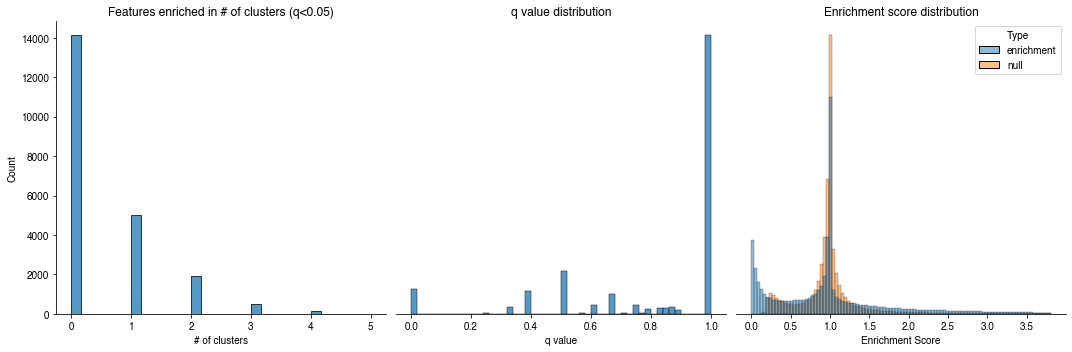

In [47]:
cluster_enriched_features(_adata,
                          cluster_col='integration_group',
                          top_n=2000,
                          alpha=0.05,
                          stat_plot=True,
                          method='rna')

In [50]:
qvals = pd.DataFrame(
    _adata.uns['integration_group_feature_enrichment']['qvals'],
    index=_adata.var_names,
    columns=_adata.uns['integration_group_feature_enrichment']
    ['cluster_order'])

qvals.to_hdf('RNA.cluster_enrichment_qvals.hdf', key='data')